In [1]:
# from preproc_tools import get_fr_by_sample, to_python_hdf5
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import json
from pathlib import Path
import h5py
from sklearn.svm import SVC
from datetime import datetime
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.results import Results
from ephysvibe.trials import  select_trials
from ephysvibe.trials.spikes import firing_rate
from typing import Dict, List
import tools_decoding
seed=1997

In [2]:
def define_contour_latencies(data, thresh):
        
    X,Y = np.where(data>=thresh)
    A=np.zeros(data.shape)
    A[X,Y]=1
    Ya,Xa    =   np.where(np.abs(np.diff(A, axis=0))!=0)
    Yb,Xb    =   np.where(np.abs(np.diff(A, axis=1))!=0)
    Yy  =   np.concatenate([Ya, Yb])
    Xx  =   np.concatenate([Xa, Xb])
    return Xx,Yy

In [3]:
def plot_grid_heatmap(mean_data,lat_data):
    xt_t = [40,85]
    xt_s = [20,65]
    label_t = ['0','450']
    label_s = ['0','450']

    samp_limit=20+65
    test_limit=105
    sample_r=int(samp_limit/10)
    test_r=int(test_limit/10)
    total_dim=(sample_r+test_r+1, sample_r+test_r+5)
    panel_dim=sample_r+test_r+1+5

    imcb0= plt.subplot2grid(shape=total_dim,  loc=(0, sample_r+test_r), colspan=1, rowspan=sample_r+test_r)

    im00 = plt.subplot2grid(shape=total_dim, loc=(0, 0), colspan=sample_r, rowspan=test_r)
    xx,yy=define_contour_latencies(lat_data[test_limit:,:samp_limit], thresh=950)
    sns.heatmap(mean_data[test_limit:,:samp_limit],ax=im00,cmap='viridis',vmin=0,vmax=1,cbar_ax=imcb0, linewidth=0,rasterized=True)
    im00.scatter(xx,yy,s=0.5,color = '#F9B233')
    im00.axes.invert_yaxis()

    im01 = plt.subplot2grid(shape=total_dim, loc=(0, sample_r), colspan=test_r, rowspan=test_r)
    xx,yy=define_contour_latencies(lat_data[test_limit:,test_limit:], thresh=950)
    sns.heatmap(mean_data[test_limit:,test_limit:],ax=im01,cmap='viridis',vmin=0,vmax=1,cbar=False, linewidth=0,rasterized=True)
    im01.scatter(xx,yy,s=0.5,color = '#F9B233')
    im01.axes.invert_yaxis()


    im10 = plt.subplot2grid(shape=total_dim, loc=(test_r, 0), colspan=sample_r, rowspan=sample_r)
    xx,yy=define_contour_latencies(lat_data[:samp_limit,:samp_limit], thresh=950)
    sns.heatmap(mean_data[:samp_limit,:samp_limit],ax=im10,cmap='viridis',vmin=0,vmax=1,cbar=False, linewidth=0,rasterized=True)
    im10.scatter(xx,yy,s=0.5,color = '#F9B233')
    im10.axes.invert_yaxis()

    im11 = plt.subplot2grid(shape=total_dim, loc=(test_r, sample_r), colspan=test_r, rowspan=sample_r)
    xx,yy=define_contour_latencies(lat_data[:samp_limit,test_limit:], thresh=950)
    sns.heatmap(mean_data[:samp_limit,test_limit:],ax=im11,cmap='viridis',vmin=0,vmax=1,cbar=False, linewidth=0,rasterized=True)
    im11.scatter(xx,yy,s=0.5,color = '#F9B233')
    im11.axes.invert_yaxis()

    im00.vlines(xt_s,0,200,'#444444','--',linewidth=1)
    im00.hlines(xt_t,0,200,'#444444','--',linewidth=1)
    im10.vlines(xt_s,0,200,'#444444','--',linewidth=1)
    im10.hlines(xt_s,0,200,'#444444','--',linewidth=1)
    im11.vlines(xt_t,0,200,'#444444','--',linewidth=1)
    im11.hlines(xt_s,0,200,'#444444','--',linewidth=1)
    im01.vlines(xt_t,0,200,'#444444','--',linewidth=1)
    im01.hlines(xt_t,0,200,'#444444','--',linewidth=1)

    im00.set_xticks([])
    im00.set_yticks(xt_t)
    im01.set_xticks([])
    im01.set_yticks([])
    im10.set_xticks(xt_s)
    im10.set_yticks(xt_s)
    im11.set_xticks(xt_t)
    im11.set_yticks([])

    im00.set_yticklabels(label_t)
    im10.set_xticklabels(label_s)
    im10.set_yticklabels(label_s)
    im11.set_xticklabels(label_t)
    im00.set_yticklabels(label_t)
    im10.set_xticklabels(label_s)
    im10.set_yticklabels(label_s)
    im11.set_xticklabels(label_t)


    return [im00, im01, im10, im11, imcb0]

In [4]:
totatest = 20
seed=1997

In [20]:
svc_c = 100000
args = {
    "preprocessing": {
        "to_decode": "orient",
        "min_ntr": 25,
        "start_sample": -200,
        "end_sample": 850,
        "start_test": -400,
        "end_test": 500,
        "step": 10,
        "time_before_son": "time_before_son_in",
        "time_before_t1on": "time_before_t1on_in",
        "sp_son": "sp_son_in",
        "sp_t1on": "sp_t1on_in",
        "mask_son": "mask_son_in",
        "no_match": False,
    },
    # decoder
    "decoder": {
        "niterations": 100,
        "ntr_train": 30,
        "ntr_test": 10,
        "svc_c": svc_c,
    },
    # workspace
    "workspace": {"output": "", "path": ""},
}

popu = PopulationData.from_python_hdf5(
    "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5"
)

list_data = popu.execute_function(
    tools_decoding.preproc_for_decoding,
    **args["preprocessing"],
    ret_df=False,
)
list_data = [idata for idata in list_data if idata is not None]
list_data = list_data[:10]
model = SVC(
    kernel="linear",
    C=args["decoder"]["svc_c"],
    decision_function_shape="ovr",
)
print(model.C)
rng = np.random.default_rng(seed)
niterations = args["decoder"]["niterations"]
ntr_train = args["decoder"]["ntr_train"]
ntr_test = args["decoder"]["ntr_test"]
to_decode = args["preprocessing"]["to_decode"]

# Decode
trial_duration = int(
    (
        (
            args["preprocessing"]["end_sample"]
            - args["preprocessing"]["start_sample"]
        )
        + (args["preprocessing"]["end_test"] - args["preprocessing"]["start_test"])
    )
    / args["preprocessing"]["step"]
)

# Decode with entire population
seeds = rng.choice(np.arange(0, 3000), size=niterations, replace=False)
results = Parallel(n_jobs=-1)(
    delayed(tools_decoding.run_decoder)(
        model, list_data, trial_duration, ntr_train, ntr_test, to_decode, seeds[it]
    )
    for it in tqdm(range(niterations))
)

# all_perf, weights = [], []
# for idata in res1ults:
#     all_perf.append(idata[0])
#     weights.append(idata[1])
# all_perf = np.array(all_perf)
# weights = np.array(weights)
# # plot res1ults
# n_cells = len(list_data)
# data = all_perf.transpose(0, 2, 1)
# # select n-1 neurons for the next iter
# mean_w = np.mean(np.abs(weights), axis=(0, 1))
# idx_sorted_w = np.argsort(mean_w)
# list_mean_w = mean_w[idx_sorted_w]
data=np.array(results)
lat_data = np.sum(data > 10, axis=0)
mean_data = np.mean(data, axis=0) / totatest

# save results
res1 = Results(
    "test_param_c.py",
    "path",
    lat_data=lat_data,
    mean_data=mean_data,
    # list_mean_w=list_mean_w,
    # n_cells=n_cells,
)

f,ax=plt.subplots(figsize=(5,5))
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
sns.heatmap(res1.mean_data,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
xx,yy=define_contour_latencies(res1.lat_data, thresh=950)

ax.scatter(xx,yy,s=0.5,color = '#F9B233')
ax.axes.invert_yaxis()
ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
# ax.vlines([105],0,190,'white',linewidth=3)
# ax.hlines([105],0,190,'white',linewidth=3)
ax.vlines([145],0,190,'#444444','--',linewidth=1)
ax.hlines([145],0,190,'#444444','--',linewidth=1)
#ax.set_title(f'C:{svc_c} {res1.n_cells}')

100%|██████████| 530/530 [00:01<00:00, 379.39it/s]


100000


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

100%|██████████| 530/530 [00:01<00:00, 353.64it/s]


0.8


100%|██████████| 10/10 [00:00<00:00, 15038.74it/s]


AttributeError: 'Results' object has no attribute 'n_cells'

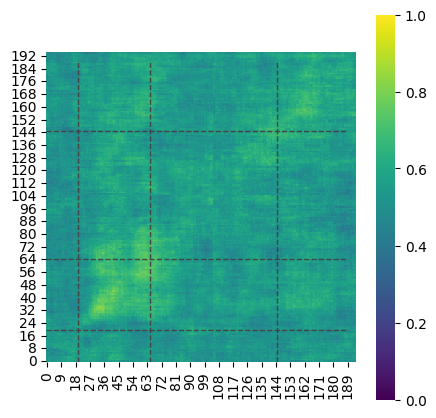

In [ ]:
svc_c = 0.8
args = {
    "preprocessing": {
        "to_decode": "orient",
        "min_ntr": 25,
        "start_sample": -200,
        "end_sample": 850,
        "start_test": -400,
        "end_test": 500,
        "step": 10,
        "time_before_son": "time_before_son_in",
        "time_before_t1on": "time_before_t1on_in",
        "sp_son": "sp_son_in",
        "sp_t1on": "sp_t1on_in",
        "mask_son": "mask_son_in",
        "no_match": False,
    },
    # decoder
    "decoder": {
        "niterations": 100,
        "ntr_train": 30,
        "ntr_test": 10,
        "svc_c": svc_c,
    },
    # workspace
    "workspace": {"output": "", "path": ""},
}

popu = PopulationData.from_python_hdf5(
    "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5"
)

list_data = popu.execute_function(
    tools_decoding.preproc_for_decoding,
    **args["preprocessing"],
    ret_df=False,
)
list_data = [idata for idata in list_data if idata is not None]
list_data = list_data[:10]
model = SVC(
    kernel="linear",
    C=args["decoder"]["svc_c"],
    decision_function_shape="ovr",
)
print(model.C)
rng = np.random.default_rng(seed)
niterations = args["decoder"]["niterations"]
ntr_train = args["decoder"]["ntr_train"]
ntr_test = args["decoder"]["ntr_test"]
to_decode = args["preprocessing"]["to_decode"]

# Decode
trial_duration = int(
    (
        (
            args["preprocessing"]["end_sample"]
            - args["preprocessing"]["start_sample"]
        )
        + (args["preprocessing"]["end_test"] - args["preprocessing"]["start_test"])
    )
    / args["preprocessing"]["step"]
)

# Decode with entire population
seeds = rng.choice(np.arange(0, 3000), size=niterations, replace=False)
results = Parallel(n_jobs=-1)(
    delayed(tools_decoding.run_decoder)(
        model, list_data, trial_duration, ntr_train, ntr_test, to_decode, seeds[it]
    )
    for it in tqdm(range(niterations))
)

# all_perf, weights = [], []
# for idata in results:
#     all_perf.append(idata[0])
#     weights.append(idata[1])
# all_perf = np.array(all_perf)
# weights = np.array(weights)
# # plot results
# n_cells = len(list_data)
# data = all_perf.transpose(0, 2, 1)
# # select n-1 neurons for the next iter
# mean_w = np.mean(np.abs(weights), axis=(0, 1))
# idx_sorted_w = np.argsort(mean_w)
# list_mean_w = mean_w[idx_sorted_w]
data=np.array(results)
lat_data = np.sum(data > 10, axis=0)
mean_data = np.mean(data, axis=0) / totatest

# save results
res2 = Results(
    "test_param_c.py",
    "path",
    lat_data=lat_data,
    mean_data=mean_data,
    # list_mean_w=list_mean_w,
    # n_cells=n_cells,
)

f,ax=plt.subplots(figsize=(5,5))
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
sns.heatmap(res2.mean_data,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
xx,yy=define_contour_latencies(res2.lat_data, thresh=950)

ax.scatter(xx,yy,s=0.5,color = '#F9B233')
ax.axes.invert_yaxis()
ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
# ax.vlines([105],0,190,'white',linewidth=3)
# ax.hlines([105],0,190,'white',linewidth=3)
ax.vlines([145],0,190,'#444444','--',linewidth=1)
ax.hlines([145],0,190,'#444444','--',linewidth=1)
#ax.set_title(f'C:{svc_c} {res2.n_cells}')

AttributeError: 'Results' object has no attribute 'list_mean_w'

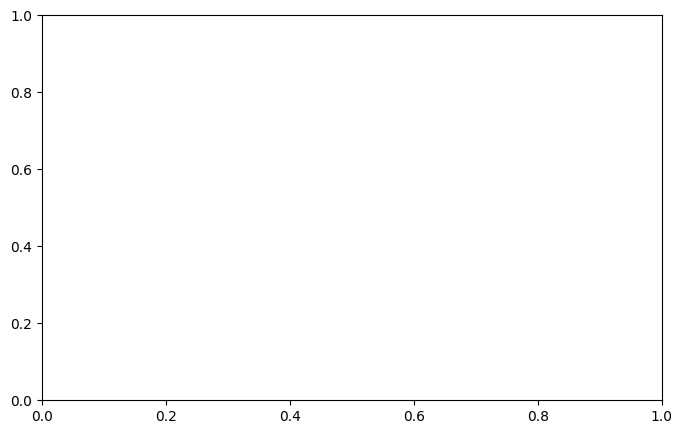

In [24]:
fig,ax=plt.subplots(figsize=(8,5))
for c in [0.1, 0.001]:
    res=Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/test_c_param/2024_09_11_16_23_10/in_rf/orient/lip/{c}/performance_decoder.h5')


    ax.scatter(range(len(res.list_mean_w)),res.list_mean_w,s=1,label=f'C:{c} {res.n_cells}')
    #ax.plot(res.list_mean_w[:384],color='k')
    ax.legend()

In [63]:
res.perf.shape

(1000, 195, 195)

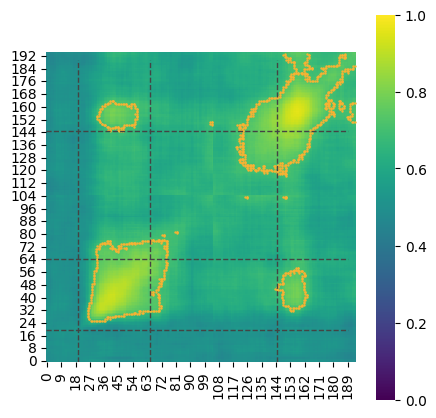

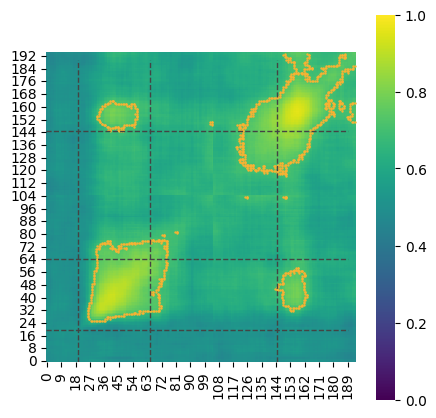

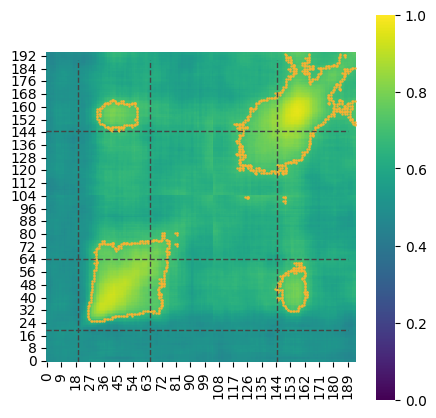

In [9]:
allres1=[]
for c in [1,0.1,0.001]:
    res=Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/test_c_param/2024_09_11_17_30_28/in_rf/orient/lip/{c}/performance_decoder.h5')
    lat_data = np.sum(res.perf > 10, axis=0)
    mean_data = np.mean(res.perf, axis=0) / totatest
    allres1.append(mean_data)
    f,ax=plt.subplots(figsize=(5,5))
    ticks= [20,65,145,190]
    label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
    sns.heatmap(mean_data,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
    xx,yy=define_contour_latencies(lat_data, thresh=950)

    ax.scatter(xx,yy,s=0.5,color = '#F9B233')
    ax.axes.invert_yaxis()
    ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
    ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
    # ax.vlines([105],0,190,'white',linewidth=3)
    # ax.hlines([105],0,190,'white',linewidth=3)
    ax.vlines([145],0,190,'#444444','--',linewidth=1)
    ax.hlines([145],0,190,'#444444','--',linewidth=1)

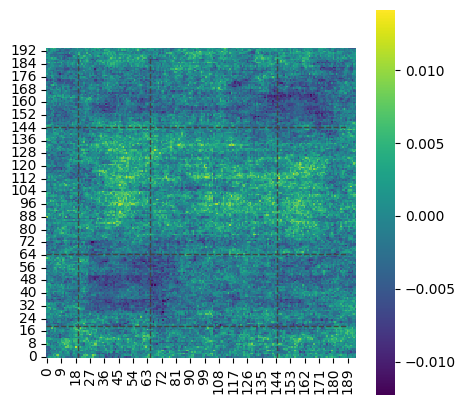

In [11]:
f,ax=plt.subplots(figsize=(5,5))
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
sns.heatmap(allres1[0]-allres1[2],ax=ax,cmap='viridis',square=True)
xx,yy=define_contour_latencies(lat_data, thresh=950)
ax.axes.invert_yaxis()
ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
# ax.vlines([105],0,190,'white',linewidth=3)
# ax.hlines([105],0,190,'white',linewidth=3)
ax.vlines([145],0,190,'#444444','--',linewidth=1)
ax.hlines([145],0,190,'#444444','--',linewidth=1)

In [19]:
np.sum(res1.mean_data-res2.mean_data)

0.0